In [1]:
import argparse
import json
from pathlib import Path
import random
import os
import schedulefree

import numpy as np
import torch
import wandb

import config
from data.utils import DataReader, get_dataset
import distributed
from models.utils import get_model
from optim.base import train
from optim.utils import cos_inf_schedule, wsd_schedule, get_batch

import sys

if 'ipykernel_launcher' in sys.argv[0]:
    sys.argv = sys.argv[:1]
    
def get_args():
    parser = argparse.ArgumentParser(allow_abbrev=False)
    parser.add_argument(
        "--config_format", default="base", choices=config.registered_formats()
    )
    args, rem_args = parser.parse_known_args()
    args.n_layer=8
    args.n_head=6
    args.n_embd=384
    args.datasets_dir = "/mntcephfs/lab_data/chenyupeng/llm_datasets"
    return config.parse_args_with_format(
        format=args.config_format, base_parser=parser, args=rem_args, namespace=args
    )

/mntcephfs/lab_data/wangsenmiao/anaconda/llama3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
args = get_args()

In [3]:
args.config_format

'base'

In [4]:
import copy

In [5]:

def get_data_readers(args, verbose=True):
    data_srcs = get_dataset(args)
    train_reader = DataReader(
        data_src=data_srcs["train"],
        batch_size=args.batch_size,
        sequence_length=args.sequence_length,
        seed=args.data_seed,
        with_replacement=False,
        auto_shard=True,
        keep_in_ram=args.data_in_ram,
    )
    val_reader = DataReader(
        data_src=data_srcs["val"],
        batch_size=args.batch_size,
        sequence_length=args.sequence_length,
        seed=args.data_seed,
        with_replacement=False,
        auto_shard=False,  # NOTE Identical Per Rank
        keep_in_ram=args.data_in_ram,
    )

    if verbose:
        print(f"Num training tokens: {train_reader.num_tokens}")
        print(f"Num validation tokens: {val_reader.num_tokens}")

    return {
        "train": train_reader,
        "val": val_reader,
    }
data = get_data_readers(args)

/mntcephfs/lab_data/chenyupeng/llm_datasets/slimpajama6B/
Num training tokens: 5827933038
Num validation tokens: 9479563


In [6]:
data

{'train': <data.utils.DataReader at 0x1554686efa50>,
 'val': <data.utils.DataReader at 0x1555502dc9d0>}

In [6]:
model = get_model(args)

In [7]:
model

Llama(
  (transformer): ModuleDict(
    (wte): Embedding(50304, 384)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-7): 8 x LlamaBlock(
        (ln_1): RMSNorm()
        (attn): LlamaAttention(
          (c_attn): Linear(in_features=384, out_features=1152, bias=False)
          (c_proj): Linear(in_features=384, out_features=384, bias=False)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): RMSNorm()
        (mlp): LlamaMLP(
          (w1): Linear(in_features=384, out_features=1024, bias=False)
          (w2): Linear(in_features=384, out_features=1024, bias=False)
          (c_proj): Linear(in_features=1024, out_features=384, bias=False)
        )
      )
    )
    (ln_f): RMSNorm()
  )
  (lm_head): Linear(in_features=384, out_features=50304, bias=False)
)

In [9]:
import torch.nn.functional as F
ckpt_list = [0,100,300,900,1500,3000,6000,9000,12000,13500,14250,15000]
w_norm_collect =[]
v_collect = []
logit_collect = []
for i in range(len(ckpt_list)):
    current_ckpt = torch.load(f"/mntcephfs/lab_data/chenyupeng/senmiao_jaggi_exp_results/slimpajama_llama_nlayers8_nhead6_lr0.002_sched_wsd_warmup1500_decay_linear_0.1_iter15000_bs50x4_ws1_seed0_data_seed1337/ckpts/{ckpt_list[i]}/main.pt",map_location=torch.device('cpu'))
    
    new_state_dict = {}
    for key, value in current_ckpt["model"].items():
        new_key = key.replace('_orig_mod.', '')  # 移除前缀
        new_state_dict[new_key] = value
    model.load_state_dict(new_state_dict)
    model_weight_norm = []
    for z in model.parameters():
        model_weight_norm.append(torch.norm(z)**2)
    model_weight_norm.append(torch.norm(model.lm_head.weight)**2)
    w_norm_collect.append(model_weight_norm)

    v_norm = []
    for z in range(len(current_ckpt["optimizer"]["state"])):
        v_norm.append(torch.norm(current_ckpt["optimizer"]["state"][z]["exp_avg_sq"])**2)
    v_collect.append(v_norm)

    outputs = model(x, targets=y, get_logits=True)
    print(f"for step {ckpt_list[i]}, logits is: ", F.softmax(outputs["logits"][0,:,:], dim=-1))
    print(f"for step {ckpt_list[i]}, logits is: ", torch.norm(outputs["logits"][0,:,:], dim=-1))
    logit_collect.append(torch.norm(outputs["logits"][0,:,:], dim=-1))
    print(f"for step {ckpt_list[i]}, loss is: ", outputs["loss"])

for step 0, logits is:  tensor([[2.7410e-05, 1.7884e-05, 4.1139e-05,  ..., 2.4227e-05, 1.5727e-05,
         2.4389e-05],
        [3.0372e-05, 1.8439e-05, 3.4815e-05,  ..., 3.0668e-05, 1.2678e-05,
         2.4830e-05],
        [2.4601e-05, 2.1545e-05, 4.0151e-05,  ..., 2.4984e-05, 1.1421e-05,
         2.7087e-05],
        ...,
        [3.4903e-05, 1.8155e-05, 1.7377e-05,  ..., 1.4580e-05, 2.2837e-05,
         2.3949e-05],
        [1.7238e-05, 1.7467e-05, 2.2741e-05,  ..., 1.4490e-05, 3.1175e-05,
         1.9585e-05],
        [1.6384e-05, 2.0149e-05, 2.4723e-05,  ..., 1.5199e-05, 3.0499e-05,
         2.5895e-05]], grad_fn=<SoftmaxBackward0>)
for step 0, logits is:  tensor([88.0662, 87.5828, 87.5337, 87.3946, 87.5565, 87.7825, 87.6164, 87.5634,
        87.5097, 87.8663, 87.6542, 87.7443, 87.7915, 87.8894, 87.8965, 87.7859,
        87.9051, 87.7130, 87.9511, 87.8006, 87.8904, 87.7043, 87.9732, 87.8106,
        87.9642, 87.9899, 87.8121, 87.9318, 88.2800, 87.6485, 88.0335, 87.8102,
        

In [8]:
x, y = get_batch(data["val"], device="cpu")
#outputs = model(x, targets=y, get_logits=True)

In [88]:
import torch.nn.functional as F
F.softmax(outputs["logits"], dim=-1)

tensor([[[1.4182e-04, 2.0143e-02, 5.1584e-03,  ..., 2.3922e-09,
          2.4639e-09, 2.5268e-09],
         [7.5259e-07, 5.7496e-08, 7.2681e-07,  ..., 3.5695e-09,
          3.5798e-09, 3.5295e-09],
         [1.1424e-07, 3.7193e-08, 1.0292e-07,  ..., 7.3888e-10,
          8.0217e-10, 7.7085e-10],
         ...,
         [9.0310e-05, 1.0836e-06, 3.3114e-07,  ..., 2.3105e-09,
          2.4500e-09, 2.3787e-09],
         [2.1500e-05, 9.3098e-08, 1.5636e-06,  ..., 8.0264e-10,
          7.7911e-10, 8.1104e-10],
         [3.3998e-02, 4.8093e-05, 3.7853e-06,  ..., 1.7680e-10,
          1.5927e-10, 1.7048e-10]],

        [[3.1804e-04, 5.0189e-04, 7.1118e-06,  ..., 3.3506e-09,
          3.2624e-09, 3.2419e-09],
         [1.4177e-05, 2.8259e-05, 9.0759e-07,  ..., 1.9377e-08,
          1.9363e-08, 1.9928e-08],
         [2.5425e-03, 1.9589e-03, 9.1875e-07,  ..., 1.2084e-09,
          1.2310e-09, 1.1925e-09],
         ...,
         [3.4397e-06, 4.0269e-06, 7.6405e-07,  ..., 6.1740e-09,
          6.103

tensor([[  198,   220,   220,  ...,   287,   262,  1956],
        [  319,   262,  1080,  ...,    11, 27635,    11],
        [ 1989,    11,   355,  ...,   761,   284,  1414],
        ...,
        [  290, 15995,  8821,  ...,   284,  8006,   351],
        [ 7464,   290,   262,  ..., 32350,   416,  1793],
        [ 2836,  7071,   290,  ...,   373,  6655,   379]])

In [36]:
v_collect = torch.tensor(v_collect[1:])

In [28]:
torch.norm(current_ckpt["optimizer"]["state"][3]["exp_avg_sq"])**2

tensor(2.4767e-11)

In [42]:
w_norm_collect = torch.tensor(w_norm_collect)
v_collect = torch.tensor(v_collect)

/tmp/ipykernel_2953609/3997711065.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v_collect = torch.tensor(v_collect)


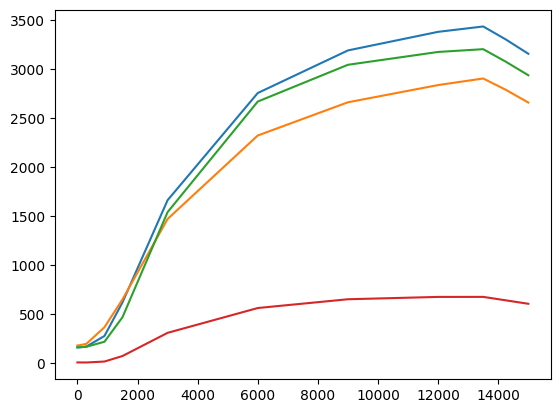

In [52]:
from matplotlib import pyplot as plt
#plt.plot(w_norm_collect[:,0],label="0")
#plt.plot(w_norm_collect[:,2],label="0")

plt.plot(ckpt_list,w_norm_collect[:,40],label="0")
plt.plot(ckpt_list,w_norm_collect[:,30],label="0")
plt.plot(ckpt_list,w_norm_collect[:,20],label="0")
plt.plot(ckpt_list,w_norm_collect[:,10],label="0")
#plt.yscale("log")
plt.show()

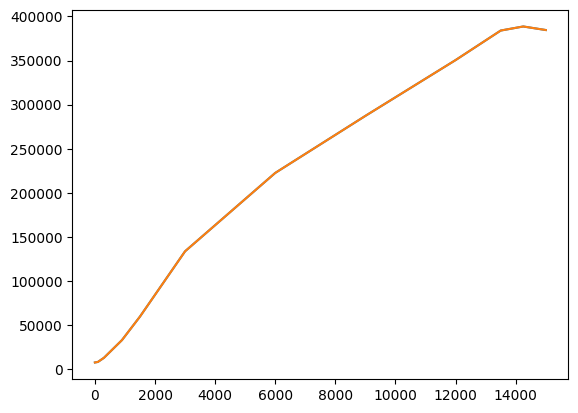

In [55]:
plt.plot(ckpt_list,w_norm_collect[:,-1],label="0")
plt.plot(ckpt_list,w_norm_collect[:,0],label="1")

tensor(7709.9512)

In [62]:
w_norm_collect[-1,-1]

tensor(384608.3750)

In [59]:
model.lm_head.weight

Parameter containing:
tensor([[ 0.0043, -0.0641, -0.1759,  ...,  0.1111,  0.1219,  0.1505],
        [-0.2183, -0.2114, -0.0254,  ..., -0.0847, -0.0113,  0.3778],
        [-0.2328, -0.0040,  0.0153,  ...,  0.1681, -0.1120, -0.0272],
        ...,
        [ 0.0419, -0.0125,  0.0464,  ...,  0.0769,  0.0128, -0.1543],
        [ 0.0303, -0.0160,  0.0545,  ...,  0.0826,  0.0090, -0.1510],
        [ 0.0271, -0.0170,  0.0534,  ...,  0.0826,  0.0077, -0.1486]],
       requires_grad=True)

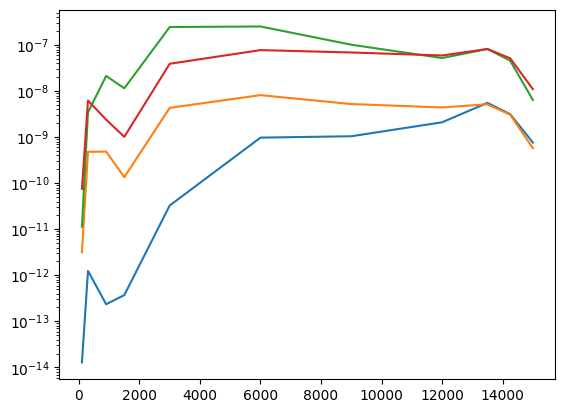

In [48]:
from matplotlib import pyplot as plt
#plt.plot(w_norm_collect[:,0],label="0")
#plt.plot(w_norm_collect[:,2],label="0")
plt.plot(ckpt_list[1:],v_collect[:,40],label="0")
plt.plot(ckpt_list[1:],v_collect[:,30],label="0")
plt.plot(ckpt_list[1:],v_collect[:,20],label="0")
plt.plot(ckpt_list[1:],v_collect[:,10],label="0")
plt.yscale("log")
plt.show()

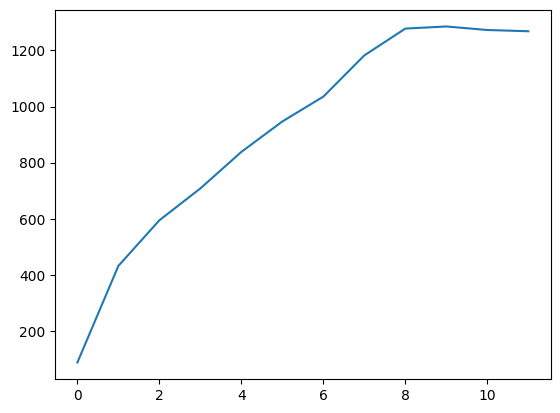

In [12]:
from matplotlib import pyplot as plt
#plt.plot(w_norm_collect[:,0],label="0")
#plt.plot(w_norm_collect[:,2],label="0")

plt.plot([torch.mean(i).detach().cpu().float() for i in logit_collect])
plt.show()

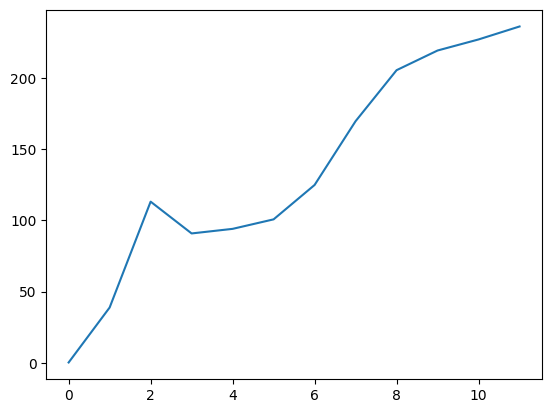

In [13]:
from matplotlib import pyplot as plt
#plt.plot(w_norm_collect[:,0],label="0")
#plt.plot(w_norm_collect[:,2],label="0")

plt.plot([torch.std(i).detach().cpu().float() for i in logit_collect])
plt.show()

In [28]:
torch.mean(logit_collect[0].cpu().detach()).float()

tensor(7679.3281)

Error in callback <function _enable_matplotlib_integration.<locals>.configure_once at 0x15545188c860> (for post_run_cell), with arguments args (<ExecutionResult object at 15545e150e10, execution_count=28 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 15545e13f890, raw_cell="torch.mean(logit_collect[0].cpu().detach()).float(.." store_history=True silent=False shell_futures=True cell_id=2b7aaf5a-dcb9-4a1f-9bde-e919459ffd06> result=tensor(7679.3281)>,),kwargs {}:


AttributeError: module 'matplotlib' has no attribute 'backends'

In [12]:
ckpt= torch.load(f"/mntcephfs/lab_data/chenyupeng/senmiao_jaggi_exp_results/slimpajama_llama_nlayers8_nhead6_lr0.002_sched_wsd_warmup1500_decay_linear_0.1_iter15000_bs50x4_ws1_seed0_data_seed1337/ckpts/9000/main.pt", map_location=torch.device('cpu'))

In [14]:
model.load_state_dict(ckpt)

RuntimeError: Error(s) in loading state_dict for Llama:
	Missing key(s) in state_dict: "transformer.wte.weight", "transformer.h.0.ln_1.weight", "transformer.h.0.attn.c_attn.weight", "transformer.h.0.attn.c_proj.weight", "transformer.h.0.ln_2.weight", "transformer.h.0.mlp.w1.weight", "transformer.h.0.mlp.w2.weight", "transformer.h.0.mlp.c_proj.weight", "transformer.h.1.ln_1.weight", "transformer.h.1.attn.c_attn.weight", "transformer.h.1.attn.c_proj.weight", "transformer.h.1.ln_2.weight", "transformer.h.1.mlp.w1.weight", "transformer.h.1.mlp.w2.weight", "transformer.h.1.mlp.c_proj.weight", "transformer.h.2.ln_1.weight", "transformer.h.2.attn.c_attn.weight", "transformer.h.2.attn.c_proj.weight", "transformer.h.2.ln_2.weight", "transformer.h.2.mlp.w1.weight", "transformer.h.2.mlp.w2.weight", "transformer.h.2.mlp.c_proj.weight", "transformer.h.3.ln_1.weight", "transformer.h.3.attn.c_attn.weight", "transformer.h.3.attn.c_proj.weight", "transformer.h.3.ln_2.weight", "transformer.h.3.mlp.w1.weight", "transformer.h.3.mlp.w2.weight", "transformer.h.3.mlp.c_proj.weight", "transformer.h.4.ln_1.weight", "transformer.h.4.attn.c_attn.weight", "transformer.h.4.attn.c_proj.weight", "transformer.h.4.ln_2.weight", "transformer.h.4.mlp.w1.weight", "transformer.h.4.mlp.w2.weight", "transformer.h.4.mlp.c_proj.weight", "transformer.h.5.ln_1.weight", "transformer.h.5.attn.c_attn.weight", "transformer.h.5.attn.c_proj.weight", "transformer.h.5.ln_2.weight", "transformer.h.5.mlp.w1.weight", "transformer.h.5.mlp.w2.weight", "transformer.h.5.mlp.c_proj.weight", "transformer.h.6.ln_1.weight", "transformer.h.6.attn.c_attn.weight", "transformer.h.6.attn.c_proj.weight", "transformer.h.6.ln_2.weight", "transformer.h.6.mlp.w1.weight", "transformer.h.6.mlp.w2.weight", "transformer.h.6.mlp.c_proj.weight", "transformer.h.7.ln_1.weight", "transformer.h.7.attn.c_attn.weight", "transformer.h.7.attn.c_proj.weight", "transformer.h.7.ln_2.weight", "transformer.h.7.mlp.w1.weight", "transformer.h.7.mlp.w2.weight", "transformer.h.7.mlp.c_proj.weight", "transformer.ln_f.weight", "lm_head.weight". 
	Unexpected key(s) in state_dict: "model", "optimizer", "scheduler", "itr". 

In [32]:
len(ckpt["optimizer"]["state"])
#[0]["exp_avg_sq"]

58

In [18]:
ckpt["model"]

OrderedDict([('_orig_mod.transformer.wte.weight',
              tensor([[ 0.0380, -0.0416, -0.1583,  ...,  0.0875,  0.1105,  0.1353],
                      [-0.1869, -0.1619, -0.0191,  ..., -0.0474, -0.0114,  0.3042],
                      [-0.1679,  0.0023,  0.0321,  ...,  0.0980, -0.1377, -0.0164],
                      ...,
                      [ 0.0686,  0.0264,  0.0315,  ...,  0.0914,  0.0550, -0.1859],
                      [ 0.0550,  0.0226,  0.0417,  ...,  0.0992,  0.0517, -0.1839],
                      [ 0.0521,  0.0226,  0.0393,  ...,  0.0985,  0.0499, -0.1796]])),
             ('_orig_mod.transformer.h.0.ln_1.weight',
              tensor([0.0771, 0.1140, 0.0732, 0.0778, 0.1468, 0.0677, 0.0819, 0.0725, 0.1877,
                      0.0624, 0.0599, 0.0842, 0.0735, 0.2298, 0.0524, 0.1138, 0.0569, 0.0774,
                      0.1038, 0.0722, 0.0657, 0.0549, 0.0806, 0.0530, 0.0609, 0.0564, 0.1025,
                      0.1490, 0.0783, 0.0676, 0.0576, 0.1265, 0.0792, 0.0619, 0

In [21]:
z = 0
for i in model.parameters():
    z+=1
z

58

In [26]:
for n,p in model.named_parameters():
    print(n)

transformer.wte.weight
transformer.h.0.ln_1.weight
transformer.h.0.attn.c_attn.weight
transformer.h.0.attn.c_proj.weight
transformer.h.0.ln_2.weight
transformer.h.0.mlp.w1.weight
transformer.h.0.mlp.w2.weight
transformer.h.0.mlp.c_proj.weight
transformer.h.1.ln_1.weight
transformer.h.1.attn.c_attn.weight
transformer.h.1.attn.c_proj.weight
transformer.h.1.ln_2.weight
transformer.h.1.mlp.w1.weight
transformer.h.1.mlp.w2.weight
transformer.h.1.mlp.c_proj.weight
transformer.h.2.ln_1.weight
transformer.h.2.attn.c_attn.weight
transformer.h.2.attn.c_proj.weight
transformer.h.2.ln_2.weight
transformer.h.2.mlp.w1.weight
transformer.h.2.mlp.w2.weight
transformer.h.2.mlp.c_proj.weight
transformer.h.3.ln_1.weight
transformer.h.3.attn.c_attn.weight
transformer.h.3.attn.c_proj.weight
transformer.h.3.ln_2.weight
transformer.h.3.mlp.w1.weight
transformer.h.3.mlp.w2.weight
transformer.h.3.mlp.c_proj.weight
transformer.h.4.ln_1.weight
transformer.h.4.attn.c_attn.weight
transformer.h.4.attn.c_proj.weight